In [12]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
import operator
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [15]:
#model
model = ChatOpenAI(model= 'gpt-4o-mini')
load_dotenv()

True

In [16]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(description= 'Detailed Feedabck of the essay')
    score: int = Field(description= 'Score out of 10', ge = 0, le = 10)

In [17]:
structured_model = model.with_structured_output(EvaluationSchema)

In [18]:
class UPSCEssay(TypedDict):
    essay: str
    depth_feedback: str
    COT_feedback: str
    language_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float



In [42]:
def depth_of_content(state: UPSCEssay):
    essay = state['essay']
    prompt = f'Evaluate depth of the analysis of the following essay and provide a detailed feedabck and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)
    return {'depth_feedback': output.feedback, 'individual_scores': [output.score]}

def clarity_of_thought(state: UPSCEssay):
    essay = state['essay']
    prompt = f'Evaluate clarity of the thought of the following essay and provide a detailed feedback and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)
    return {'COT_feedback': output.feedback, 'individual_scores': [output.score]}

def language_of_essay(state: UPSCEssay):
    essay = state['essay']
    prompt = f'Evaluate language and the grammer used of the following essay and provide a detailed feedabck and assign a score out of 10 \n {essay}'
    output = structured_model.invoke(prompt)
    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

def overall_feedback(state: UPSCEssay):
    prompt = f"Based upon the following feedback, create a summarized version of the feedback given on the essay, where \n language feedback {state['language_feedback']} \n clarity of thought feedback {state['COT_feedback']} \n depth of the content feedback {state['depth_feedback']}"
    final_output = model.invoke(prompt).content
    
    #avg score
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall_feedback': final_output, 'avg_score': avg_score}





In [43]:
graph = StateGraph(UPSCEssay)
graph.add_node('depth_of_content', depth_of_content)
graph.add_node('clarity_of_thought', clarity_of_thought)
graph.add_node('language_of_essay', language_of_essay)
graph.add_node('feedback_summary', overall_feedback)
graph.add_edge(START, 'depth_of_content')
graph.add_edge(START, 'clarity_of_thought')
graph.add_edge(START, 'language_of_essay')
graph.add_edge('depth_of_content', 'feedback_summary')
graph.add_edge('clarity_of_thought', 'feedback_summary')
graph.add_edge('language_of_essay', 'feedback_summary')

workflow = graph.compile()

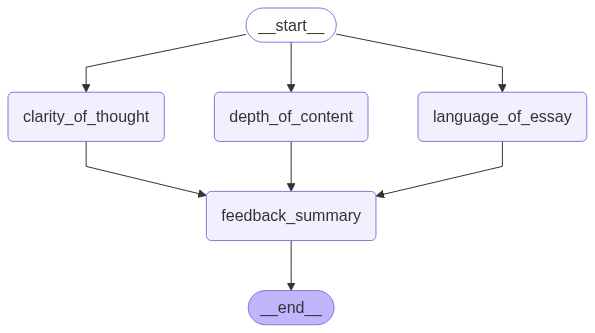

In [44]:
workflow

In [45]:
essay = '''Climate change is no longer a future problem, it is already here and impacting lives across the globe. For a developing country like India, which is still grappling with poverty and inequality, the challenges posed by climate change are enormous. Rising temperatures, unpredictable rainfall patterns, and frequent extreme weather events like floods, droughts, and cyclones are all becoming common.

Agriculture, which is the backbone of the Indian economy and employs more than 50percent of the population, is being directly affected. Crops are failing due to irregular monsoons and increasing water stress. This is creating a big impact on rural livelihoods and also food security of the country. Besides, coastal areas like Sundarbans and cities like Mumbai and Chennai are at risk due to rising sea levels and storm surges.

India is also witnessing increasing heat waves, especially in northern and central parts, making living conditions worse, particularly for the poor who do not have access to air conditioning or proper shelter. Cities are becoming heat islands and this is only going to increase with urbanisation.

The government has taken steps like the National Action Plan on Climate Change and also ratifying the Paris Agreement, but implementation on ground is still lacking. There is need for stronger political will, public awareness and technological innovation to combat the issue.

In conclusion, climate change is not just an environmental problem, but also a social and economic threat. India needs to act fast and act now before things go beyond control. It is not just the duty of the government, but every citizen must contribute by adopting more sustainable lifestyles.

'''

In [46]:
output = workflow.invoke({'essay': essay})

In [47]:
print(output)

{'essay': 'Climate change is no longer a future problem, it is already here and impacting lives across the globe. For a developing country like India, which is still grappling with poverty and inequality, the challenges posed by climate change are enormous. Rising temperatures, unpredictable rainfall patterns, and frequent extreme weather events like floods, droughts, and cyclones are all becoming common.\n\nAgriculture, which is the backbone of the Indian economy and employs more than 50percent of the population, is being directly affected. Crops are failing due to irregular monsoons and increasing water stress. This is creating a big impact on rural livelihoods and also food security of the country. Besides, coastal areas like Sundarbans and cities like Mumbai and Chennai are at risk due to rising sea levels and storm surges.\n\nIndia is also witnessing increasing heat waves, especially in northern and central parts, making living conditions worse, particularly for the poor who do no

In [48]:
type(output)

dict

In [50]:
for key, value in output.items():
    print(f"{key} : {value}")

essay : Climate change is no longer a future problem, it is already here and impacting lives across the globe. For a developing country like India, which is still grappling with poverty and inequality, the challenges posed by climate change are enormous. Rising temperatures, unpredictable rainfall patterns, and frequent extreme weather events like floods, droughts, and cyclones are all becoming common.

Agriculture, which is the backbone of the Indian economy and employs more than 50percent of the population, is being directly affected. Crops are failing due to irregular monsoons and increasing water stress. This is creating a big impact on rural livelihoods and also food security of the country. Besides, coastal areas like Sundarbans and cities like Mumbai and Chennai are at risk due to rising sea levels and storm surges.

India is also witnessing increasing heat waves, especially in northern and central parts, making living conditions worse, particularly for the poor who do not have 